<a href="https://colab.research.google.com/github/Madhukar-Palakaveeti/deep_learning/blob/main/neural_net_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Imports
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# @title Spiral dataset generation function
def generate_spiral_dataset(num_classes, num_samples_per_class, noise=0.2):
    X = []
    y = []

    for class_idx in range(num_classes):
        radius = np.linspace(0, 1, num_samples_per_class)
        theta = np.linspace(class_idx * 4, (class_idx + 1) * 4, num_samples_per_class) + np.random.randn(num_samples_per_class) * noise

        X_class = np.column_stack([radius * np.sin(theta), radius * np.cos(theta)])
        X.append(X_class)
        y.append(np.ones(num_samples_per_class, dtype= np.int8) * class_idx)

    X = np.vstack(X)
    y = np.hstack(y)

    return X, y

In [3]:
X, y = generate_spiral_dataset(3, 100)
y[:5]

array([0, 0, 0, 0, 0], dtype=int8)

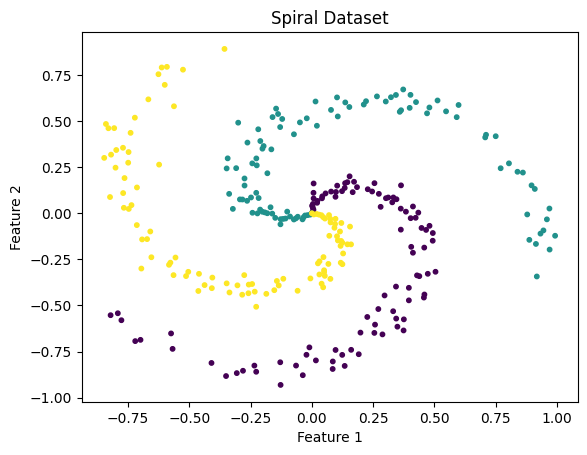

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10)
plt.title('Spiral Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [5]:

# @title Converting labels into one-hot encoded vectors
y_true = np.zeros((len(y), len(np.unique(y))))
y_true[np.arange(len(y)), y] = 1
y_true[:5]


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [6]:
# @title Neural Network
class Layer_Dense:
  def __init__(self,n_inputs,n_neurons):
    self.weights = 0.01 * np.random.randn(n_inputs,n_neurons)
    self.biases = np.zeros((1,n_neurons))

  def forward(self,inputs):
    self.output = np.dot(inputs, self.weights)+ self.biases

  def parameters(self):
    return self.weights

class Activation_ReLU:
  def forward(self,inputs):
    self.output = np.maximum(0,inputs)

class Activation_Softmax:
  def forward(self,inputs):
    exp_values = np.exp(inputs - np.max(inputs,axis=1,keepdims=True))
    probabilities = exp_values/np.sum(exp_values,axis=1,keepdims=True)
    self.output = probabilities


class Loss_Categoricalcrossentropy():
  def forward(self, probs, y_true):
    samples = len(probs)
    probs_clipped = np.clip(probs, 1e-7, 1 - 1e-7)
    #negative_log_likelihoods = -np.sum(y_true*np.log(probs_clipped))
    #final_loss = np.sum(negative_log_likelihoods)/samples
    correct_confidences = np.sum(probs_clipped * y_true, axis=1)
    n_l_l = -np.log(correct_confidences)
    final_loss = np.mean(n_l_l)
    return final_loss


In [7]:
# @title Creating the layers and activations
layer1 = Layer_Dense(2,3)
layer2 = Layer_Dense(3,3)
activation1 = Activation_ReLU()
activation2 = Activation_Softmax()

In [135]:
# @title Forward Pass

layer1.forward(X[277])
activation1.forward(layer1.output)
a1 = activation1.output

layer2.forward(activation1.output)
activation2.forward(layer2.output)
logits = activation2.output

In [11]:
# @title Calculating the loss and accuracy
loss_function = Loss_Categoricalcrossentropy()
loss = loss_function.forward(logits,y_true)
print(f"Loss : {loss}")

y_pred = np.argmax(activation2.output,axis=1)
accuracy = np.mean(y_pred == y)

print(f"Accuracy:{accuracy*100}")

Loss : 1.09861231429437
Accuracy:33.33333333333333


In [ ]:
# @title BackPropogation
#getting the weights
w1 = layer1.weights
w2 = layer2.weights
dz2 = logits - y_true
dw2 = a1.T @ dz2
da1 = dz2 @ w2.T
dz1 = np.maximum(0,da1)
dw1 = X.T @ dz1
print(dz1)

[[0.         0.         0.09561067 0.         0.        ]
 [0.         0.         0.09564145 0.         0.        ]
 [0.         0.         0.09565409 0.         0.        ]
 ...
 [0.22875118 0.         0.07943615 0.         0.15754141]
 [0.23060664 0.         0.0809134  0.         0.15869764]
 [0.22993486 0.         0.08037871 0.         0.158279  ]]


In [130]:
# @title Gradient Descent
learning_rate = 0.00075
# layer1.weights -= learning_rate * dw1
# layer2.weights -= learning_rate * dw2



In [ ]:
1print(dz2.shape)
print(layer2.biases)
print(np.sum(dz2,axis=0))

(300, 3)
[[0. 0. 0.]]
[-0.0052892   0.00743991 -0.00215072]


In [134]:
for i in range(50):
  layer1.forward(X)
  activation1.forward(layer1.output)
  a1 = activation1.output

  layer2.forward(activation1.output)
  activation2.forward(layer2.output)
  logits = activation2.output
  loss = loss_function.forward(logits,y_true)

  y_pred = np.argmax(activation2.output,axis=1)
  accuracy = np.mean(y_pred == y)

  w1 = layer1.weights
  w2 = layer2.weights
  dz2 = logits - y_true
  dw2 = a1.T @ dz2
  db2 = np.sum(dz2,axis=0)
  da1 = dz2 @ w2.T
  dz1 = da1 * (a1 > 0)
  dw1 = X.T @ dz1
  db1 = np.sum(dz1,axis=0)

  layer1.weights -= learning_rate * dw1
  layer2.weights -= learning_rate * dw2
  layer1.biases -= learning_rate * db1
  layer2.biases -= learning_rate * db2
print(f"Loss : {loss}")
print(f"Accuracy:{accuracy*100}")

Loss : 0.5628018153270896
Accuracy:74.0


In [136]:
print(y[277])
print(logits)

2
[[3.00413111e-04 1.35540351e-01 8.64159236e-01]]


True

In [138]:
w1 = layer1.weights
w2 = layer2.weights
b1 = layer1.biases
b2 = layer2.biases

In [140]:
print(w1)
print(w2)
print(b1)
print(b2)

[[-3.52990873 -5.03247449  2.85145763]
 [-4.1865843  -2.63604393  3.78394523]]
[[ 4.12102256 -2.156952   -1.95707842]
 [-3.01728871  1.51410247  1.50776823]
 [ 2.71679121 -0.72553461 -1.95836704]]
[[3.57196616 1.63719812 1.27475645]]
[[-12.94294712   6.1115558    6.83139132]]
